In [2]:
import torch
import time
import gemm_cutlass
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = "cuda:2"
torch.cuda.set_device(device)
dtype = torch.bfloat16

In [4]:
k0 = 1536
n0 = 6144
k1 = 6144
n1 = 1536

bias0 = torch.zeros((1, n0), dtype=dtype, device=device)
bias1 = torch.zeros((1, n1), dtype=dtype, device=device)

gemm0 = torch.randn((n0, k0), dtype=dtype, device=device)
gemm1 = torch.randn((n1, k1), dtype=dtype, device=device)

# m = batch_size * sequence_length
shapes = torch.load("ffn_inputShapes.pt")
m_values = set()  # 使用集合去重
for shape in shapes:
    m = shape[0] * shape[1]  
    m_values.add(m) 

In [5]:
def benchmark(shapes, device, dtype, warmup_iters=10, test_iters=20):
    results = []

    for shape in shapes:
        input = torch.randn(torch.Size(shape), device=device, dtype=dtype)
        m = input.shape[0] * input.shape[1]
        print(f"Processing shape {shape} with m={m}")

        # Torch warm-up
        for _ in range(warmup_iters):
            _ = input @ gemm0.T
            _ = _ @ gemm1.T

        # Torch timing
        # 大部分情况下，torch.matmul()调用cuBLAS进行矩阵乘法
        torch_times = []
        for _ in range(test_iters):
            torch_out0 = input @ gemm0.T
            torch.cuda.synchronize(device); start = time.time()
            torch_out1 = torch_out0 @ gemm1.T
            torch.cuda.synchronize(device); end = time.time()
            torch_times.append((end - start) * 1000)
        torch_time = sum(torch_times) / len(torch_times)

        # GemmBasic timing
        gemm_basic_times = []
        for _ in range(test_iters):
            cutlass_out0 = gemm_cutlass.GemmBasic(input, gemm0, bias0, None, None) # (m, n0) = (m, k0) X (k0, n0)
            torch.cuda.synchronize(device); start = time.time()
            cutlass_out1 = gemm_cutlass.GemmBasic(cutlass_out0, gemm1, bias1, None, None) # (m, n1) =  (m, n0) X (n0, n1)
            torch.cuda.synchronize(device); end = time.time()
            gemm_basic_times.append((end - start) * 1000)
        gemm_basic_time = sum(gemm_basic_times) / len(gemm_basic_times)
        gemm_basic_diff = (torch_out1.flatten() - cutlass_out1.flatten()).max().item()

        # GemmStreamK warm-up
        for _ in range(warmup_iters):
            cutlass_out0SK = gemm_cutlass.GemmStreamK(input, gemm0, bias0, None, None, None)
            cutlass_out1SK = gemm_cutlass.GemmStreamK(cutlass_out0SK, gemm1, bias1, None, None, None)

        # GemmStreamK timing
        gemm_streamk_times = []
        for _ in range(test_iters):
            cutlass_out0SK = gemm_cutlass.GemmStreamK(input, gemm0, bias0, None, None, None)
            torch.cuda.synchronize(device); start = time.time()
            cutlass_out1SK = gemm_cutlass.GemmStreamK(cutlass_out0SK, gemm1, bias1, None, None, None)
            torch.cuda.synchronize(device); end = time.time()
            gemm_streamk_times.append((end - start) * 1000)
        gemm_streamk_time = sum(gemm_streamk_times) / len(gemm_streamk_times)
        gemm_streamk_diff = (torch_out1.flatten() - cutlass_out1SK.flatten()).max().item()


        # Calculate speedup
        speedup_basic = torch_time / gemm_basic_time
        speedup_streamk = torch_time / gemm_streamk_time
        speedup_cutlass = gemm_basic_time / gemm_streamk_time
        # Store the results
        results.append({
            "m": m,
            "torch_time_ms": torch_time,
            "gemm_basic_time_ms": gemm_basic_time,
            "gemm_basic_diff": gemm_basic_diff,
            "speedup_basic": speedup_basic,
            "gemm_streamk_time_ms": gemm_streamk_time,
            "gemm_streamk_diff": gemm_streamk_diff,
            "speedup_streamk": speedup_streamk,
            "speedup_cutlass": speedup_cutlass,

        })

    return results

In [6]:
results = benchmark(shapes, device, dtype)

Processing shape tensor([  12,  154, 1536]) with m=1848
Processing shape tensor([  12,  256, 1536]) with m=3072
Processing shape tensor([  26,  154, 1536]) with m=4004
Processing shape tensor([  26,  390, 1536]) with m=10140
Processing shape tensor([  26,  405, 1536]) with m=10530
Processing shape tensor([  26,  464, 1536]) with m=12064
Processing shape tensor([  26,  527, 1536]) with m=13702
Processing shape tensor([  26,  576, 1536]) with m=14976
Processing shape tensor([  26,  700, 1536]) with m=18200
Processing shape tensor([  26,  858, 1536]) with m=22308
Processing shape tensor([  26, 1296, 1536]) with m=33696
Processing shape tensor([  27,  154, 1536]) with m=4158
Processing shape tensor([  27,  312, 1536]) with m=8424
Processing shape tensor([  27,  350, 1536]) with m=9450
Processing shape tensor([  27, 1196, 1536]) with m=32292
Processing shape tensor([  28,  154, 1536]) with m=4312
Processing shape tensor([  28,  312, 1536]) with m=8736
Processing shape tensor([  28,  464, 15

In [7]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Save results to a txt file
df_results.to_csv("benchmark_results_2.txt", index=False, sep='\t')

print("Benchmark completed. Results saved to benchmark_results.txt")

Benchmark completed. Results saved to benchmark_results.txt


In [8]:
data = pd.read_csv('benchmark_results_2.txt', sep='\t')
df = pd.DataFrame(data)
index = range(len(df))
df = df.sort_values(by="m", ascending=True)

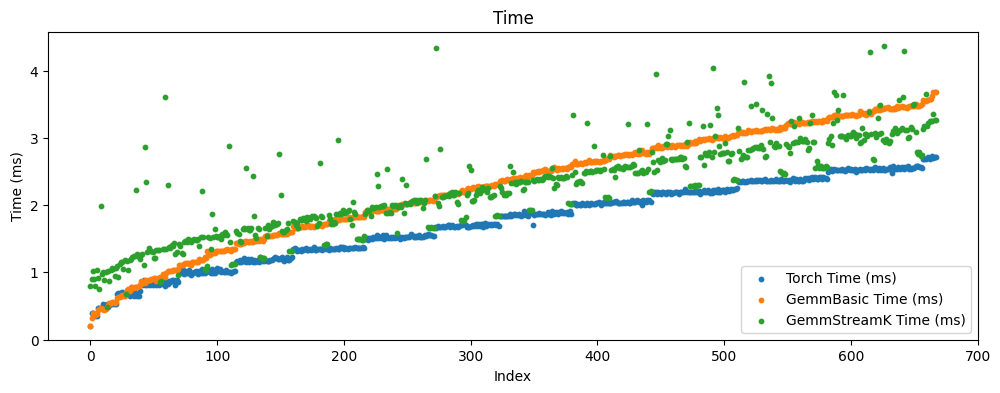

In [9]:
plt.figure(figsize=(12, 4))
bar_width = 0.35
plt.scatter(index, df["torch_time_ms"], label="Torch Time (ms)", s=10)
plt.scatter(index, df["gemm_basic_time_ms"], label="GemmBasic Time (ms)", s=10)
plt.scatter(index, df["gemm_streamk_time_ms"], label="GemmStreamK Time (ms)", s=10)

# plt.bar(index , df["torch_time_ms"], label="Torch Time (ms)")
# plt.bar(index , df["gemm_basic_time_ms"], label="GemmBasic Time (ms)")
# plt.bar(index , df["gemm_streamk_time_ms"], label="GemmStreamK Time (ms)")
plt.title("Time")
plt.xlabel("Index")
plt.ylabel("Time (ms)")
plt.legend()
plt.show()

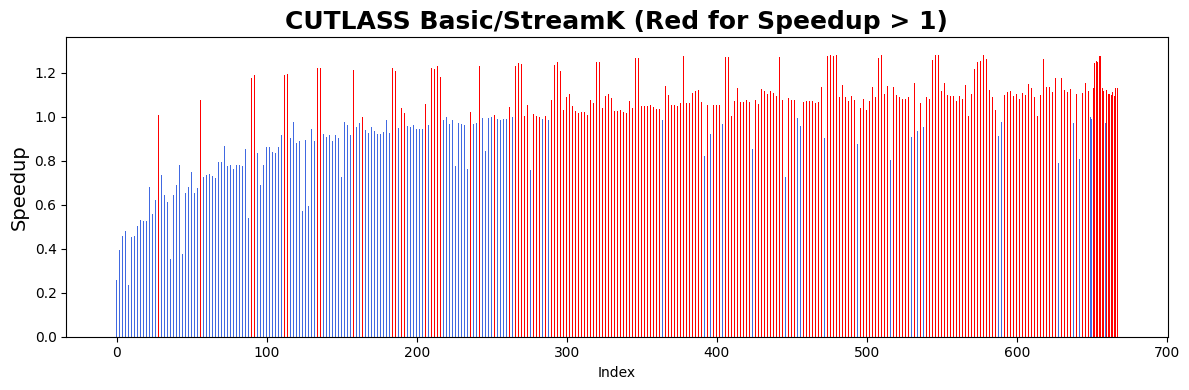

In [12]:
mask = df["speedup_cutlass"] > 1

plt.figure(figsize=(12, 4))
bar_width = 0.35
index = range(len(df))

colors = ["red" if is_above_1 else "royalblue" for is_above_1 in mask]

plt.bar(index, df["speedup_cutlass"], width=bar_width, color=colors)
plt.title("CUTLASS Basic/StreamK (Red for Speedup > 1)", fontsize=18, fontweight='bold')
plt.ylabel("Speedup", fontsize=14)
plt.xlabel("Index")
plt.tight_layout()
plt.show()

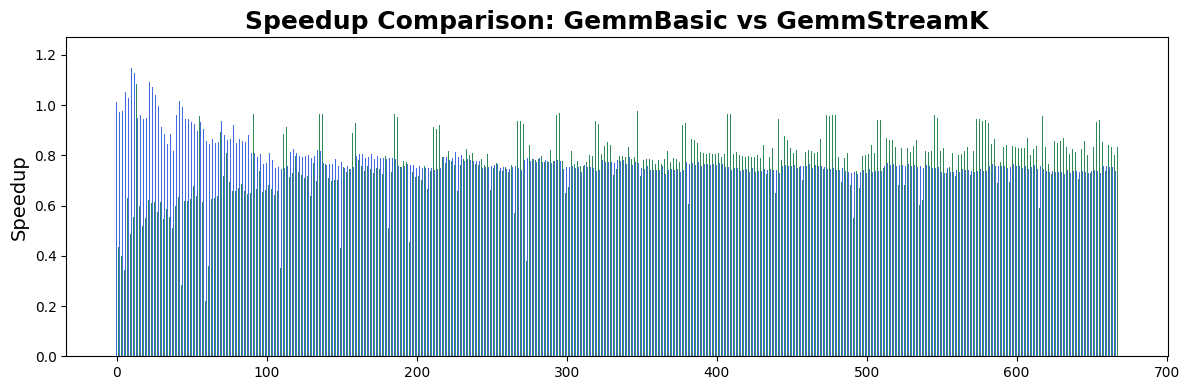

In [10]:
import matplotlib.pyplot as plt

# 绘制柱状图
plt.figure(figsize=(12, 4))
index = range(len(df))
df = df.sort_values(by="m", ascending=True)
# 绘制柱状图
bar_width = 0.35
plt.bar(index, df["speedup_basic"], width=bar_width, label="Speedup GemmBasic", color="royalblue")
plt.bar([i + bar_width for i in index], df["speedup_streamk"], width=bar_width, label="Speedup GemmStreamK", color="seagreen")

# 添加标题和轴标签
plt.title("Speedup Comparison: GemmBasic vs GemmStreamK", fontsize=18, fontweight='bold')
# plt.xlabel("Shape Index", fontsize=14)
plt.ylabel("Speedup", fontsize=14)

# 调整图例位置和样式
# plt.legend(title="Method", title_fontsize='13', loc='upper left', fontsize='12', frameon=True)

# 设置x轴的刻度
# plt.xticks([i + bar_width/2 for i in index], index)

# 显示图表
plt.tight_layout()
plt.show()


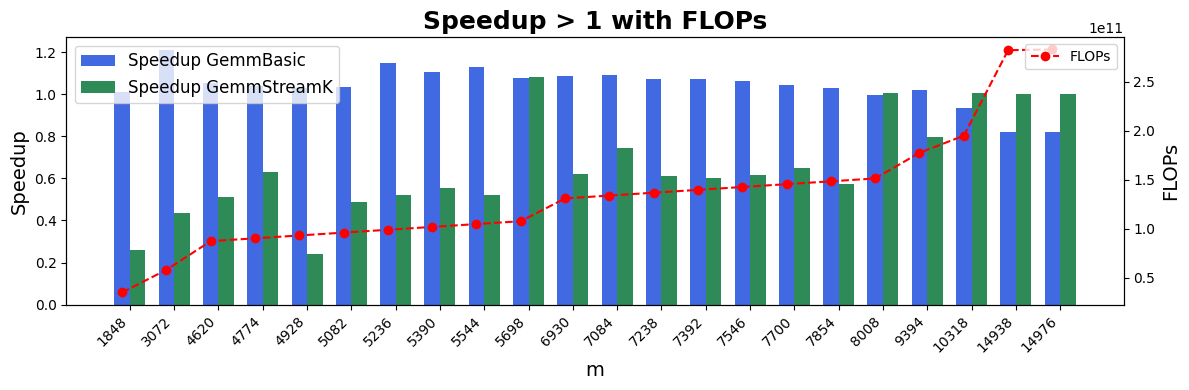

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df_filtered = df[(df["speedup_basic"] > 1) | (df["speedup_streamk"] > 1)]
df_filtered = df_filtered.sort_values(by="m", ascending=True)

if not df_filtered.empty:
    # 计算 FLOPs
    df_filtered['flops'] = df_filtered['m'] * 1536 * 6144 * 2

    plt.figure(figsize=(12, 4))
    index = range(len(df_filtered))

    bar_width = 0.35
    plt.bar(index, df_filtered["speedup_basic"], width=bar_width, label="Speedup GemmBasic", color="royalblue")
    plt.bar([i + bar_width for i in index], df_filtered["speedup_streamk"], width=bar_width, label="Speedup GemmStreamK", color="seagreen")

    plt.title("Speedup > 1 with FLOPs", fontsize=18, fontweight='bold')
    plt.xlabel("m", fontsize=14)
    plt.ylabel("Speedup", fontsize=14)
    plt.legend(title_fontsize='13', loc='upper right', fontsize='12', frameon=True)
    plt.legend(title_fontsize='13', loc='upper left', fontsize='12', frameon=True)

    m_values = df_filtered["m"].tolist()  # 获取 m 值作为 x 轴标签
    plt.xticks([i + bar_width / 2 for i in index], m_values, rotation=45, ha="right")

    ax2 = plt.gca().twinx()
    ax2.plot(index, df_filtered["flops"], color='red', marker='o', label="FLOPs", linestyle='--')
    ax2.set_ylabel("FLOPs", fontsize=14)
    ax2.legend(loc='upper right')


    plt.tight_layout()
    plt.show()
else:
    print("No data points with speedup > 1.")

In [15]:
poor_performance = df[(df['speedup_cutlass'] < 0.8)]
poor_performance = poor_performance.sort_values(by="speedup_cutlass", ascending=True)
print(poor_performance[['m', 'speedup_cutlass']])

         m  speedup_cutlass
54    4928         0.234486
4    10530         0.257046
0     1848         0.257471
13    9450         0.293635
382   8932         0.352390
..     ...              ...
503  11550         0.786234
286  33600         0.789735
489  11242         0.794960
71   11550         0.796106
568  30800         0.798905

[101 rows x 2 columns]


In [16]:
better_performance = df[(df['speedup_cutlass'] > 1.2)]
better_performance = better_performance.sort_values(by="speedup_cutlass", ascending=False)
print(better_performance[['m', 'speedup_cutlass']])

         m  speedup_cutlass
598  28800         1.297295
140  28749         1.285234
317  28800         1.283942
599  29952         1.282888
628  31096         1.281255
..     ...              ...
112  16128         1.213967
150  21888         1.209990
133  17168         1.209373
627  16016         1.205066
647  17248         1.203730

[79 rows x 2 columns]
